In [2]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy.linalg as LA
import copy

In [23]:
def float_constrain(x, _min, _max):
    if x > _max:
        return _max
    if x < _min:
        return _min
    return x

def generate_random_position(params, last, step=1, step_z=0.3):
    if step is not None:
        x = float_constrain((random.random()*2-1) * step + last[0], params["xmin"], params["xmax"])
        y = float_constrain((random.random()*2-1) * step + last[1], params["ymin"], params["ymax"])
        z = float_constrain((random.random()*2-1) * step_z + last[2], params["zmin"], params["zmax"])
    else:
        x = random.random()* (params["xmax"]- params["xmin"]) + params["xmin"]
        y = random.random()* (params["ymax"]- params["ymin"]) + params["ymin"]
        z = random.random()* (params["zmax"]- params["zmin"]) + params["zmin"]
        
    return np.array([x, y, z])

def generate_random_formation(nodes, params, last, step=1):
    ret_poses = {}

    for _id in nodes:
        if _id in last:
            last_pos = last[_id]
        else:
            last_pos = None
        pos = generate_random_position(params, last_pos, step) 
        yaw = random.random()*6.28-3.14
        
        for idj in ret_poses:
            while LA.norm(ret_poses[idj][0:2] - pos[0:2]) < params["planar_safe_distance"]:
                pos = generate_random_position(params, last_pos, step)
        
        if params["local_frame"]:
            #Elimate start point
            pos = pos - np.array(nodes[_id]["start_point"])
        ret_poses[_id] = [pos[0], pos[1], pos[2], yaw]
    return ret_poses

def generate_random_mission(nodes, params):
    poses_stamped =  { _id:[] for _id in nodes} # {id: [T X Y Z YAW]}
    ret = {}
    init_z = params["init_z"]
    step = params["step"]
    for _id in nodes:
        p0 = nodes[_id]["start_point"]
        ret[_id] = np.array([p0[0], p0[1], p0[2]+init_z])
        poses_stamped[_id].append(np.array([0, 0, 0, init_z, 0]))

    for i in range(params["points"]):
        ts = (i+1)*params["t_duration"]
        ret = generate_random_formation(nodes, params, ret, step=step)
        for _id in ret:
            arr = copy.copy(ret[_id])
            arr.insert(0, ts)
            poses_stamped[_id].append(arr)
    print(poses_stamped[1])
    return poses_stamped

def generate_random_missions_to_files(nodes, params, folder="", show=True, mission_id=0):
    missions = generate_random_mission(nodes, params)
    if show:
        fig = plt.figure(f"Trajs", figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax = fig.gca(projection='3d')
        
    for _id in missions:
        mission = np.array(missions[_id])
        if (show):
            ax.plot(mission[:,1], mission[:,2],mission[:,3], label=f"Trajectory {_id}")
            plt.grid()
            ax.set_xlabel('$X$')
            ax.set_ylabel('$Y$')
            ax.set_zlabel('$Z$')
    
    
        np.savetxt(f"{folder}/mission_{mission_id}_drone{_id}.csv", mission, fmt="%.3f")

[array([0., 0., 0., 1., 0.]), [5.0, -0.5094476507229069, 1.4828794289224678, 0.8929737904690056, 1.7068609489830986], [10.0, 0.7032426922652215, 0.8473232500165184, 1.1773192324851969, 2.615890044192755], [15.0, -2.298692269728573, 1.3695186304381557, 0.9122172437385461, 1.10889150802292], [20.0, 0.09955362942276746, 0.09660951135241813, 0.8323716351382819, 0.5802352036475229], [25.0, 1.0644414457920037, -0.8616953183698753, 0.7765219324322461, 0.7886475251865073], [30.0, 0.37038775601842566, 1.2437217445098985, 1.0205463960715975, -2.772601575538029], [35.0, 1.227788307954616, -0.5408506366511128, 0.808848354938302, -1.3657103206535484], [40.0, -0.007647954413087632, -0.4086042149769513, 0.7220669292602042, 1.9115874406575641], [45.0, -0.6728403686229236, 0.18883687786176795, 1.0982686200760747, -3.0405266427821656], [50.0, -1.6927026110506154, 1.2600175597676797, 0.9331824787410339, 3.1113485940986725], [55.0, 1.4339250440934386, 1.74094638425131, 1.1357403836123212, 1.20975054629651

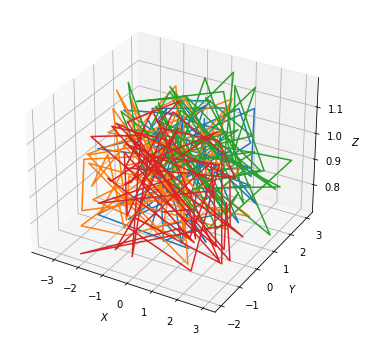

In [29]:
random_mission_params = {
    "xmin": -2.5,
    "xmax": 3,
    "ymin": -1,
    "ymax": 2,
    "zmin": 0.7,
    "zmax": 1.2,
    "local_frame": True,
    "t_duration": 5.0,
    "points": 60,
    "planar_safe_distance": 1.0,
    "init_z": 1.0,
    "step" : None
}

nodes = {
    1: {
        "start_point": [0.0, 0.0, 0.0]
    },
    2:{
        "start_point": [1.0, 0.0, 0.0]
    },
    3: {
        "start_point": [0.0, -1.0, 0.0]
    },
    4: {
        "start_point": [0.0, 1.0, 0.0]
    },
}

generate_random_missions_to_files(nodes, random_mission_params, "missions")